Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin_Cancer/Train") # Given Gdrive path to access train images
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin_Cancer/Test")   # Given Gdrive path to access test images

In [4]:
# No of images available for training and testing

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, image_size=(180, 180), seed=123, batch_size=32,
                                                               validation_split=0.2, subset='training',label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, image_size=(180, 180), seed=123, batch_size=32,
                                                               validation_split=0.2, subset='validation',label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [76]:
len(class_names)

9

There are a total 9 different types of skin diseases

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

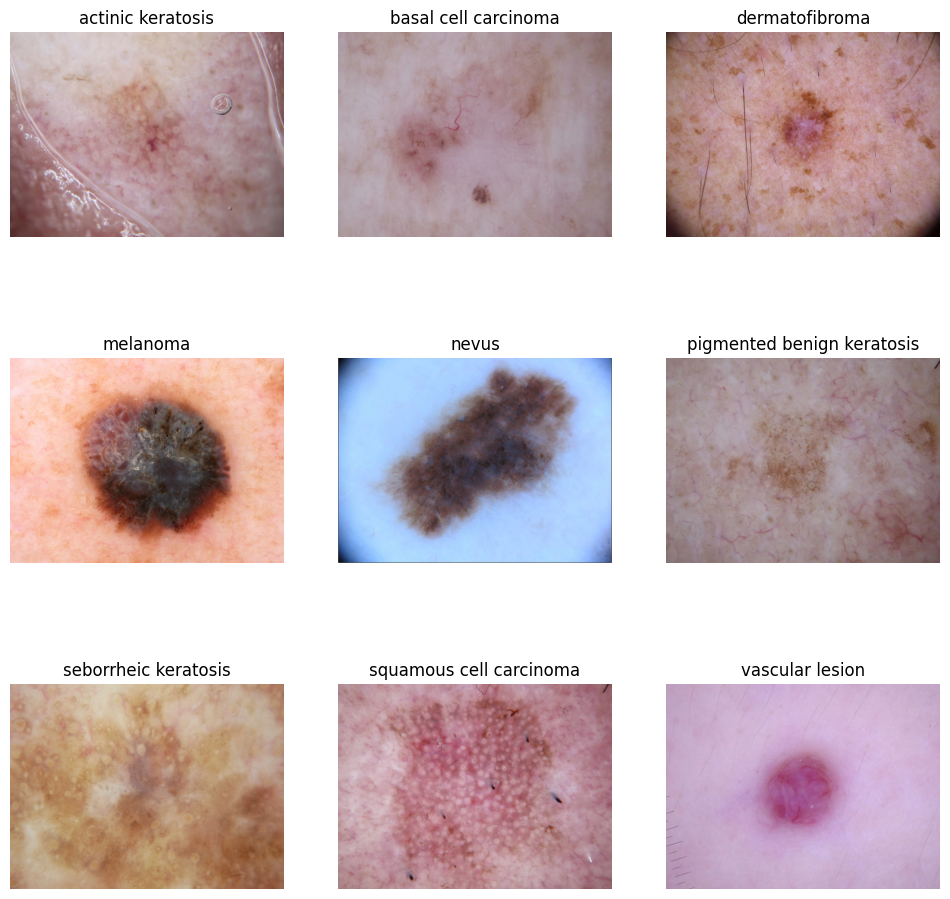

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0]))
    plt.title(class_names[i])
    plt.axis('off')
    plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
# Importing required methods to build CNN network

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling, BatchNormalization

**Model 1 - Without Dropouts and Without BatchNormalisation techniques**

In [12]:
### Your code goes here
num_classes = 9
model = Sequential()

# Defining Rescaling Layer
model.add(keras.Input(shape=(180, 180, 3)))
model.add(Rescaling(1./255))

# Convolution layers
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                   

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 472s 2s/step - loss: 2.0177 - accuracy: 0.2461 - val_loss: 1.9898 - val_accuracy: 0.2438
Epoch 2/20
56/56 [==============================] - 3s 59ms/step - loss: 1.8128 - accuracy: 0.3348 - val_loss: 1.7577 - val_accuracy: 0.3758
Epoch 3/20
56/56 [==============================] - 3s 60ms/step - loss: 1.6863 - accuracy: 0.3862 - val_loss: 1.5510 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: 1.5964 - accuracy: 0.4224 - val_loss: 1.6068 - val_accuracy: 0.4004
Epoch 5/20
56/56 [==============================] - 3s 61ms/step - loss: 1.5381 - accuracy: 0.4425 - val_loss: 1.4974 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 3s 60ms/step - loss: 1.3813 - accuracy: 0.5140 - val_loss: 1.3720 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 3s 61ms/step - loss: 1.3379 - accuracy: 0.5335 - val_loss: 1.3893 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing training results

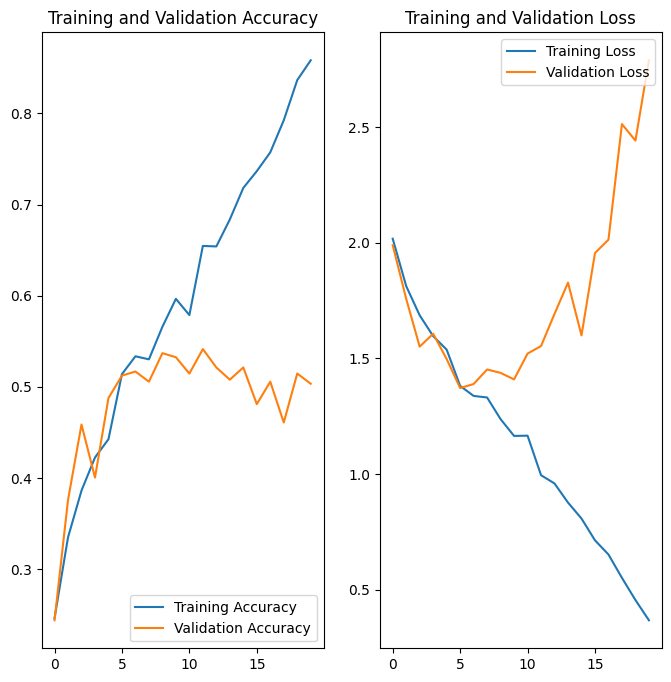

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

*   A notable variance exists between the training accuracy and validation accuracy, suggesting the model's inability to effectively generalize and predict unseen data.
*   High training accuracy coupled with low validation accuracy signifies overfitting.
*   Implementing dropouts can be a valuable strategy to address these issues and enhance model performance.












In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 17ms/step - loss: 2.7893 - accuracy: 0.5034
Accuracy:  0.8850446343421936
Validation Accuracy:  0.5033556818962097
Loss:  0.28236424922943115
Validation Loss 2.7893407344818115


In [18]:
# Your code goes here
# Let us artificially expand the training dataset by applying various transformations to the existing data samples.
# It helps in improving the generalization and robustness of CNN
Augmented_data= keras.Sequential([
layers.RandomFlip(mode="horizontal_and_vertical",input_shape=(180,180,3)),
layers.RandomRotation(0.25, fill_mode='reflect'),
layers.RandomZoom(height_factor=0.4, width_factor=0.3, fill_mode='reflect'),
layers.RandomCrop(height= 300, width=350, seed =100)
])

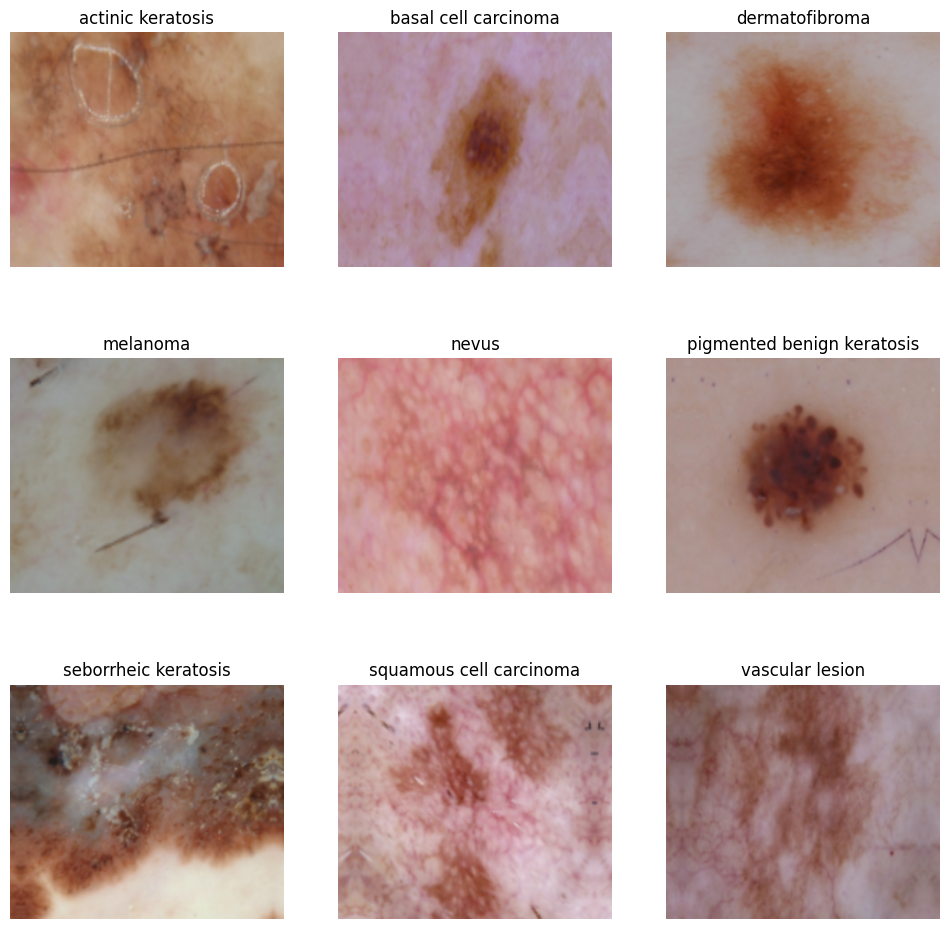

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(Augmented_data(images)[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


**Model 2 - Using Modified Images**

In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

num_classes = 9
model = Sequential(Augmented_data) # Adding augmented data to the model

# Defining Rescaling Layer
model.add(keras.Input(shape=(180, 180, 3)))
model.add(Rescaling(1./255))

# Convolution layers
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.35))

model.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [21]:
## Your code goes here
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 300, 350, 3)       0         
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 rescaling_1 (Rescaling)     (None, 300, 350, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 298, 348, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 296, 346, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 148, 173, 32)      0         
 g2D)                                                            
                                                      

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 32s 349ms/step - loss: 2.2997 - accuracy: 0.1775 - val_loss: 2.0432 - val_accuracy: 0.2125
Epoch 2/20
56/56 [==============================] - 17s 306ms/step - loss: 2.0080 - accuracy: 0.2388 - val_loss: 1.8962 - val_accuracy: 0.2841
Epoch 3/20
56/56 [==============================] - 17s 297ms/step - loss: 1.9270 - accuracy: 0.2640 - val_loss: 1.7720 - val_accuracy: 0.3669
Epoch 4/20
56/56 [==============================] - 16s 294ms/step - loss: 1.8554 - accuracy: 0.3119 - val_loss: 1.7684 - val_accuracy: 0.3848
Epoch 5/20
56/56 [==============================] - 17s 302ms/step - loss: 1.7454 - accuracy: 0.3722 - val_loss: 1.7169 - val_accuracy: 0.4072
Epoch 6/20
56/56 [==============================] - 16s 289ms/step - loss: 1.6856 - accuracy: 0.3817 - val_loss: 1.8354 - val_accuracy: 0.3378
Epoch 7/20
56/56 [==============================] - 16s 290ms/step - loss: 1.7124 - accuracy: 0.3901 - val_loss: 1.5130 - val_accuracy: 0.4452

### Visualizing the results

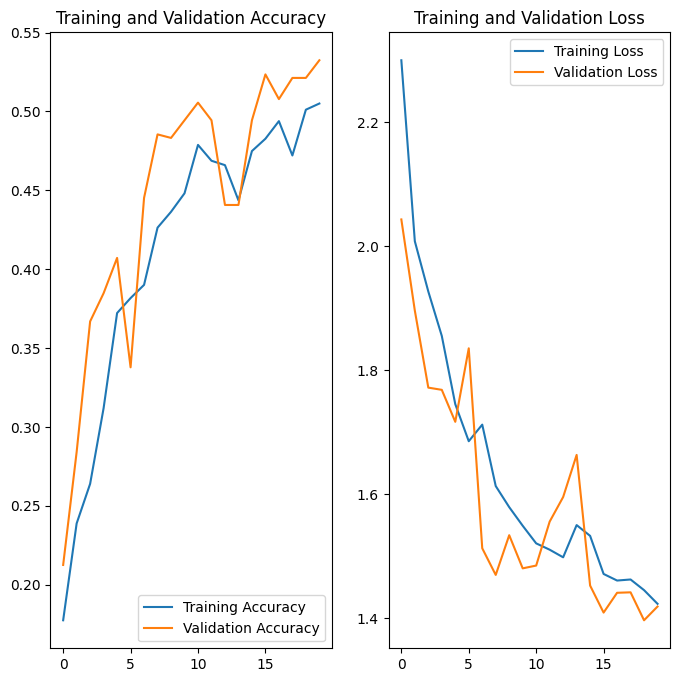

In [24]:
bacc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bacc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 1s 49ms/step - loss: 1.4191 - accuracy: 0.5324
Accuracy:  0.5256696343421936
Validation Accuracy:  0.5324384570121765
Loss:  1.318311333656311
Validation Loss 1.4191126823425293


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

*   A notable decrease in the disparity between training accuracy and validation accuracy suggests enhanced generalizability and indicates that overfitting has been mitigated.
*   Despite this improvement, the overall accuracy remains relatively low, hovering around 50%, indicating the model's limited ability to accurately predict unseen data.
*   The current situation appears to be indicative of underfitting. Implementing techniques such as batch normalization could be explored to address this issue and potentially improve the model's performance.













#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
## Your code goes here.
from glob import glob

## find the image path for all class labels (lesions)
list_images_path = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ] #retrieve a list of file paths for all .jpg files within the specified directory

## Extract the class labels (lesions)
list_lesions = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(list_lesions))

2239


In [27]:
# Extract image path and class label in a dictionary

image_path_dict = dict(zip(list_images_path, list_lesions)) # Creating a dictionary when image paths are mapped to lesions
print(list(image_path_dict.items())[:3])

[('/content/gdrive/MyDrive/Skin_Cancer/Train/dermatofibroma/ISIC_0025622.jpg', 'dermatofibroma'), ('/content/gdrive/MyDrive/Skin_Cancer/Train/dermatofibroma/ISIC_0026789.jpg', 'dermatofibroma'), ('/content/gdrive/MyDrive/Skin_Cancer/Train/dermatofibroma/ISIC_0027107.jpg', 'dermatofibroma')]


In [28]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_path_dict.items()), columns=['Image-Path', 'Disease']) # Creating a df consists of image path and diseases
lesions_df.head()

,Image-Path,Disease
0,/content/gdrive/MyDrive/Skin_Cancer/Train/derm...,dermatofibroma
1,/content/gdrive/MyDrive/Skin_Cancer/Train/derm...,dermatofibroma
2,/content/gdrive/MyDrive/Skin_Cancer/Train/derm...,dermatofibroma
3,/content/gdrive/MyDrive/Skin_Cancer/Train/derm...,dermatofibroma
4,/content/gdrive/MyDrive/Skin_Cancer/Train/derm...,dermatofibroma


In [29]:
## Inspecting the distribution of classes in the data
lesions_df[['Disease']].value_counts()

Disease                   
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

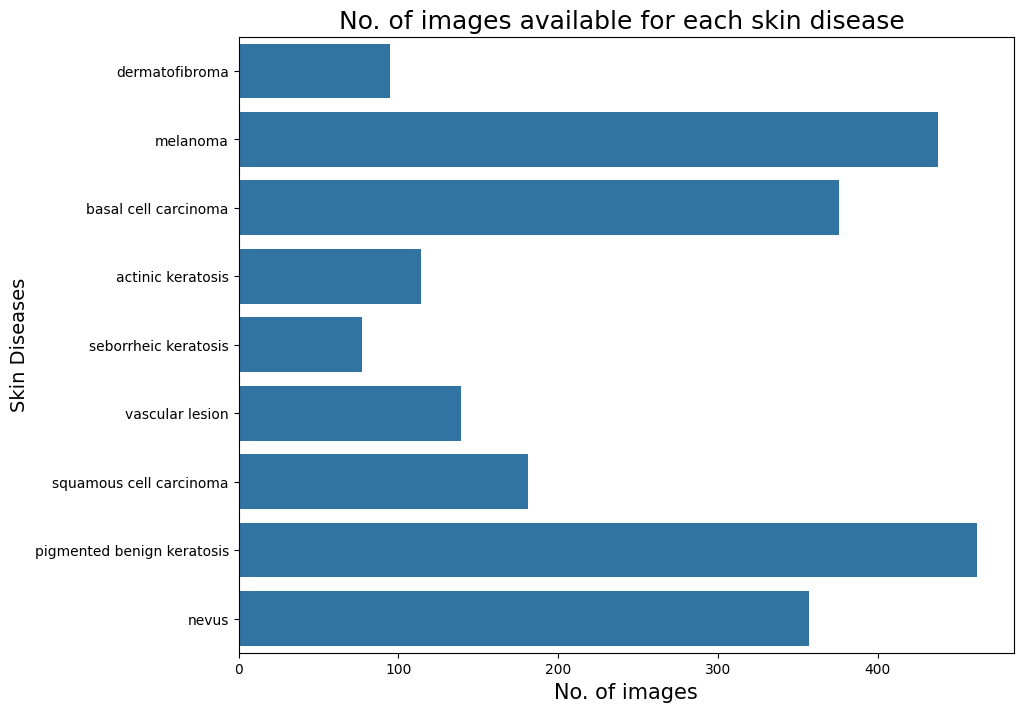

In [30]:
# Visualize the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Disease", data=lesions_df)
plt.title('No. of images available for each skin disease ', fontsize=18)
plt.xlabel('No. of images', fontsize=15)
plt.ylabel('Skin Diseases', fontsize=14)
plt.show()

In [31]:
round(lesions_df[['Disease']].value_counts(normalize=True)*100, 2)

Disease                   
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


*   **seborrheic keratosis** class has less numbers of samples
*   **pigmented benign keratosis** has more number of samples



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset= str(data_dir_train) + '/'  # Creating a string variable
import Augmentor
for c in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + c)  # creating a pipeline for data augmentation
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B567C79B760>: 100%|██████████| 500/500 [00:22<00:00, 22.69 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B567C7B76D0>: 100%|██████████| 500/500 [00:22<00:00, 22.61 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B568113A680>: 100%|██████████| 500/500 [00:20<00:00, 24.51 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7B567C7F3BE0>: 100%|██████████| 500/500 [01:22<00:00,  6.03 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7B567C624850>: 100%|██████████| 500/500 [01:29<00:00,  5.57 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B567C647C70>: 100%|██████████| 500/500 [00:20<00:00, 23.83 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B56800698D0>: 100%|██████████| 500/500 [00:41<00:00, 12.13 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B5700064460>: 100%|██████████| 500/500 [00:18<00:00, 27.33 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B56F059BB50>: 100%|██████████| 500/500 [00:20<00:00, 24.62 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


*   Modified images have been added to the directory under output folder for each class




### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
aug_path_list = [i for i in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
aug_path_list[:5]

['/content/gdrive/MyDrive/Skin_Cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031271.jpg_0ca55270-7ace-456e-b21f-d00206573c1f.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031429.jpg_42e66d4c-5f8a-44ac-be92-63ba0c3df9db.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026473.jpg_4414811c-a795-428d-96c8-fc76b3cf2c57.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029973.jpg_c1e7337c-07e1-42d2-b541-ac6c2c004f9e.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032941.jpg_a2d051f5-2434-41b8-b167-b0429f89f63d.jpg']

In [36]:
new_list_lesions = [os.path.basename(os.path.dirname(os.path.dirname(i))) for i in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
new_list_lesions[:5]

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma']

In [37]:
new_dict= dict(zip(aug_path_list, new_list_lesions))

In [38]:
new_df = pd.DataFrame(list(new_dict.items()),columns = ['Path','Label'])
final_df = pd.concat([lesions_df, new_df])

In [39]:
final_df['Label'].value_counts()

Label
dermatofibroma                500
melanoma                      500
basal cell carcinoma          500
actinic keratosis             500
seborrheic keratosis          500
vascular lesion               500
squamous cell carcinoma       500
pigmented benign keratosis    500
nevus                         500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size =(180, 180),
  label_mode='categorical',
  batch_size=32)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(180, 180),
  label_mode='categorical',
  batch_size=32)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [45]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

**Model 3 - Using added training data and BatchNormalisation technique**

In [53]:
## your code goes here
num_classes = 9
model = Sequential()

# Defining Rescaling Layer
model.add(keras.Input(shape=(180, 180, 3)))
model.add(Rescaling(1./255))

# Convolution layers
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.35))

model.add(Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [54]:
## your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 conv2d_21 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_13 (Ba  (None, 176, 176, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 88, 88, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 86, 86, 64)       

#### **Todo:**  Train your model

In [56]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 22s 114ms/step - loss: 1.7763 - accuracy: 0.3476 - val_loss: 2.4113 - val_accuracy: 0.1299
Epoch 2/50
169/169 [==============================] - 19s 111ms/step - loss: 1.4418 - accuracy: 0.4460 - val_loss: 2.3346 - val_accuracy: 0.1901
Epoch 3/50
169/169 [==============================] - 19s 111ms/step - loss: 1.3198 - accuracy: 0.4989 - val_loss: 1.4348 - val_accuracy: 0.4202
Epoch 4/50
169/169 [==============================] - 19s 111ms/step - loss: 1.2318 - accuracy: 0.5376 - val_loss: 1.2916 - val_accuracy: 0.5137
Epoch 5/50
169/169 [==============================] - 18s 109ms/step - loss: 1.1945 - accuracy: 0.5532 - val_loss: 2.8942 - val_accuracy: 0.3177
Epoch 6/50
169/169 [==============================] - 19s 110ms/step - loss: 1.0718 - accuracy: 0.5983 - val_loss: 1.3549 - val_accuracy: 0.5509
Epoch 7/50
169/169 [==============================] - 19s 111ms/step - loss: 1.0001 - accuracy: 0.6352 - val_loss: 7.9480 - val_ac

#### **Todo:**  Visualize the model results

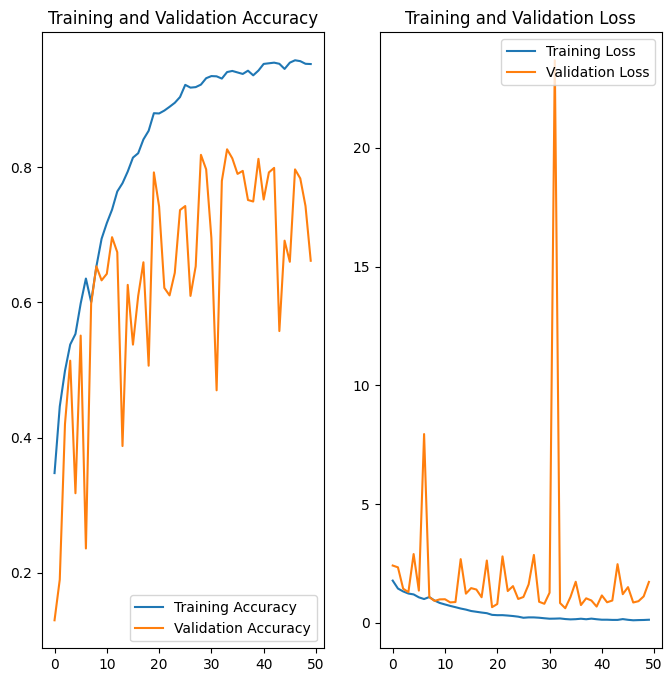

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*   Observing the depicted graph, it's evident that the validation accuracy exhibits significant fluctuations across epochs, indicating instability within the model.
*   Despite enhancements in training accuracy, the inconsistent behavior of validation accuracy renders the model less dependable.
*   Considering these concerns, a decision is made to construct an alternative model architecture devoid of Batch Normalization layers.












**Model 4 -  without BatchNormalisation**

In [67]:
## your code goes here
num_classes = 9
model = Sequential()

# Defining Rescaling Layer
model.add(keras.Input(shape=(180, 180, 3)))
model.add(Rescaling(1./255))

# Convolution layers
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.35))

model.add(Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [68]:
## your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

# The ModelCheckpoint callback is employed during training with model.fit() to periodically save the model or its weights into a checkpoint file.
# This allows for the possibility of reloading the model or weights later on to resume training from the saved point.

checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# Terminate the training process when a monitored metric no longer shows improvement.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [69]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 conv2d_29 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 88, 88, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                

#### **Todo:**  Train your model

In [70]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 29s 88ms/step - loss: 2.0723 - accuracy: 0.1858 - val_loss: 1.8903 - val_accuracy: 0.2673
Epoch 2/50
169/169 [==============================] - 14s 84ms/step - loss: 1.8113 - accuracy: 0.2947 - val_loss: 1.6307 - val_accuracy: 0.3563
Epoch 3/50
169/169 [==============================] - 14s 84ms/step - loss: 1.6187 - accuracy: 0.3685 - val_loss: 1.5063 - val_accuracy: 0.4143
Epoch 4/50
169/169 [==============================] - 14s 84ms/step - loss: 1.5451 - accuracy: 0.3895 - val_loss: 1.4266 - val_accuracy: 0.4298
Epoch 5/50
169/169 [==============================] - 15s 88ms/step - loss: 1.4952 - accuracy: 0.4099 - val_loss: 1.5414 - val_accuracy: 0.4135
Epoch 6/50
169/169 [==============================] - 14s 85ms/step - loss: 1.4563 - accuracy: 0.4267 - val_loss: 1.2964 - val_accuracy: 0.4826
Epoch 7/50
169/169 [==============================] - 14s 83ms/step - loss: 1.4270 - accuracy: 0.4479 - val_loss: 1.3287 - val_accuracy:

#### **Todo:**  Visualize the model results

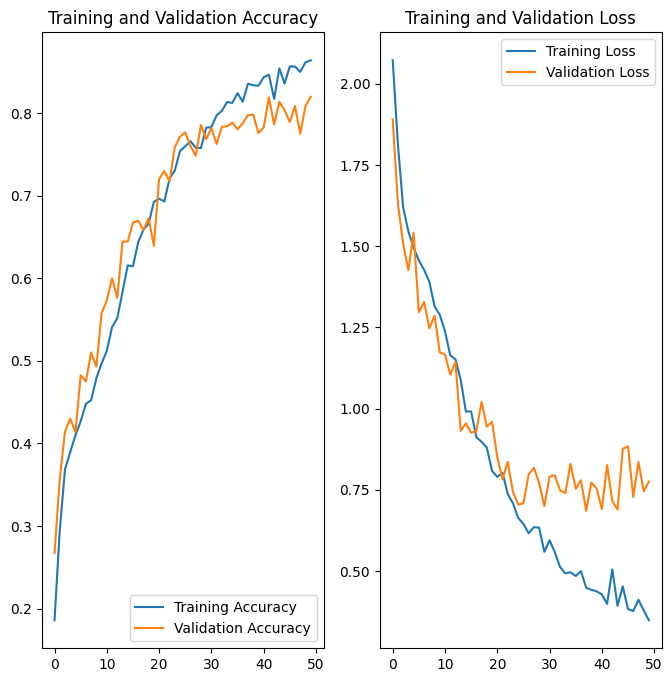

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



*   Balancing the class distribution in the dataset can indeed contribute to improving the generalization and robustness of the model.
*   The minimal difference in accuracies and consistently high values suggest that the model has learned to generalize well across both the training and validation datasets.




1/1 [==============================] - 0s 22ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


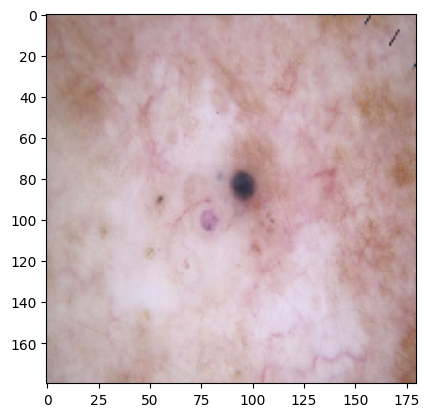

In [75]:
# Assessing the performance of our model on a single instance from the test set.

from glob import glob
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

The model has predicted correctly